In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import  transforms, datasets
from tqdm import tqdm

In [2]:
# transform for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'data'
train_data_dir = 'data/train'   # training data
test_data_dir = 'data/test'     # testing data


In [4]:
os.listdir(data_dir)

['test', 'train']

In [5]:
print(f"train: {os.listdir(train_data_dir)}")
print(f"test: {os.listdir(test_data_dir)}")

train: ['cat', 'dog']
test: ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg', '10015.jpg', '10016.jpg', '10017.jpg', '10018.jpg', '10019.jpg', '1002.jpg', '10020.jpg', '10021.jpg', '10022.jpg', '10023.jpg', '10024.jpg', '10025.jpg', '10026.jpg', '10027.jpg', '10028.jpg', '10029.jpg', '1003.jpg', '10030.jpg', '10031.jpg', '10032.jpg', '10033.jpg', '10034.jpg', '10035.jpg', '10036.jpg', '10037.jpg', '10038.jpg', '10039.jpg', '1004.jpg', '10040.jpg', '10041.jpg', '10042.jpg', '10043.jpg', '10044.jpg', '10045.jpg', '10046.jpg', '10047.jpg', '10048.jpg', '10049.jpg', '1005.jpg', '10050.jpg', '10051.jpg', '10052.jpg', '10053.jpg', '10054.jpg', '10055.jpg', '10056.jpg', '10057.jpg', '10058.jpg', '10059.jpg', '1006.jpg', '10060.jpg', '10061.jpg', '10062.jpg', '10063.jpg', '10064.jpg', '10065.jpg',

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}

In [7]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 25000
     Root location: data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [120]:
# split the data into training and validation sets
train_size = int(0.8 * len(image_datasets['train']))
val_size = len(image_datasets['train']) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(image_datasets['train'], [train_size, val_size])

# create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [9]:
dataset_sizes

{'train': 20000, 'val': 5000}

In [10]:
def counter_sample_images(dataset):
    count = {}
    for _, label in dataset:
        if label not in count:
            count[label] = 0
        count[label] += 1
    return count

print(f"train: {counter_sample_images(train_dataset)}")
print(f"val: {counter_sample_images(val_dataset)}")

train: {1: 9997, 0: 10003}
val: {1: 2503, 0: 2497}


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from models import ViT
from configs import ViT_config
import torchsummary as summary

model = ViT(**ViT_config).to(device)
summary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 14, 14]         196,864
        InputLayer-2             [-1, 197, 256]               0
         LayerNorm-3             [-1, 197, 256]             512
            Linear-4             [-1, 197, 256]          65,536
            Linear-5             [-1, 197, 256]          65,536
            Linear-6             [-1, 197, 256]          65,536
            Linear-7             [-1, 197, 256]          65,792
           Dropout-8             [-1, 197, 256]               0
MultiHeadSelfAttention-9             [-1, 197, 256]               0
        LayerNorm-10             [-1, 197, 256]             512
           Linear-11             [-1, 197, 256]          65,792
             GELU-12             [-1, 197, 256]               0
          Dropout-13             [-1, 197, 256]               0
           Linear-14             [-

In [46]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [85]:
from PIL import Image
img1 = Image.open("data/test/1.jpg")

In [94]:
def get_attention_map(model, img):
    x = model.input_layer(data_transforms['train'](img).unsqueeze(0).to(device))
    x = model.encoder(x)
    return x.squeeze(0).detach().cpu().numpy()

In [113]:
def predict(model, img, classnames):
    pred = model(data_transforms['train'](img).unsqueeze(0).to(device))
    score = nn.functional.softmax(pred, dim=1)[0]
    label = torch.argmax(score)
    return classnames[predicted.item()], score[predicted.item()].item()

In [116]:
import matplotlib.pyplot as plt
def plot_attention_map(original_img, attention_map):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig.set_tight_layout(True)
    model_predict = predict(model, original_img, image_datasets['train'].classes)
    original_img = original_img.resize((224, 224))
    fig.suptitle(f"Predicted: {model_predict[0]} - {model_predict[1]}", fontsize=16)
    ax[0].imshow(original_img)
    ax[1].imshow(attention_map)
    plt.show()

In [118]:
def validate_model(model, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print('[VALIDATE] Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [119]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0

    
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        print('[TRAINING] Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        validate_model(model, criterion)
        plot_attention_map(img1, get_attention_map(model, img1))
        
    return model

Epoch 0/24
----------
[TRAINING] Loss: 0.6265 Acc: 0.6417
[VALIDATE] Loss: 0.6119 Val Acc: 0.6646


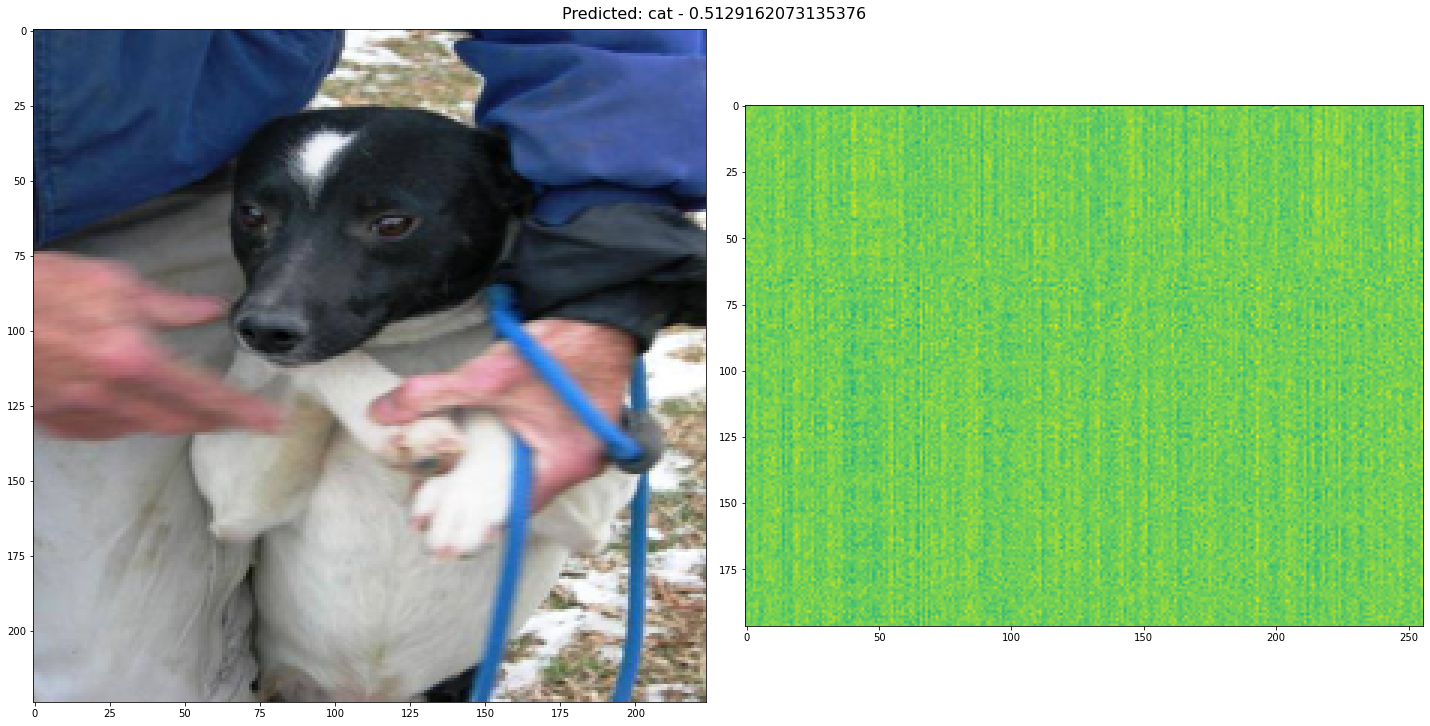

Epoch 1/24
----------


KeyboardInterrupt: 

In [121]:
train_model(model, criterion, optimizer, num_epochs=25)